#### Desafio 2 PS-EPTA - Payload
##### Alex dos Santos Burdelis

#### Introdução
Este notebook analisa os dados reais de voo do foguete Nashira, da Equipe de Propulsão e Tecnologia Aeroespacial (EPTA) da UFU, obtidos por telemetria durante a competição LASC 2025. Além da análise dos dados experimentais (arquivo `nashira_flight.csv`), é realizada uma comparação com uma simulação teórica construída com a biblioteca RocketPy.
Durante o desenvolvimento foi utilizado auxílio de IA generativa - mais especificamente o Gemini Pro e o copilot ChatGPT-5 mini - para apoio na escrita e revisão de trechos de código (simulação, processamento de dados com pandas, visualizações e cálculos como média móvel e regressão linear).

Para auxiliar na leitura dos dados do arquivo de telemetria, um resumo das grandezas:

###### TEMPO
- `timestamp_ms` (ms) — Tempo de execução do processador.
- `gnss_time` (UTC) — Horário UTC obtido via GNSS.

###### POSICIONAMENTO (GPS)
- `lat`, `lon` (graus) — Coordenadas geográficas (latitude e longitude).
- `alt_gps` (m) — Altitude geométrica (elipsoidal).
- `gnss_fix` (int) — Qualidade do fix GNSS.
- `gnss_sats` (int) — Número de satélites visíveis.

###### ATMOSFERA
- `alt_bar` (m) — Altitude barométrica — principal medida para análise de apogeu.
- `pressure` (Pa) — Pressão atmosférica local.
- `temperature` (°C) — Temperatura interna do sensor.

###### NAVEGAÇÃO (Filtro)
- `pos_n`, `pos_e` (m) — Posição Norte / Leste.
- `pos_d` (m) — Posição vertical (negativo = subindo, positivo = descendo).
- `vel_n`, `vel_e`, `vel_d` (m/s) — Velocidades nas direções Norte, Leste e Vertical 

###### SENSORES BRUTOS
- `acc_x_raw`, `acc_y_raw`, `acc_z_raw` (g) — Acelerações brutas nos eixos do corpo.
- `gyro_x`, `gyro_y`, `gyro_z` (deg/s) — Taxas de giro (velocidade angular).
- `mag_x`, `mag_y`, `mag_z` (µT) — Leitura do campo magnético.

###### ATITUDE (Orientação)
- `roll`, `pitch`, `yaw` (graus) — Ângulos que definem a orientação (direção do bico).

###### ESTADO
- `flight_state` (int) — Estado detectado do voo (rampa, subida, descida).
- flags `*_valid` (0/1) — Indicadores de integridade dos dados (1 = confiável).


In [35]:
#imports
from rocketpy import Environment, Rocket, SolidMotor, Flight
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import math

### 1. Environment

In [36]:
env = Environment(
    latitude=-21.9416,
    longitude=-48.9527,
    elevation=463, #altitude-> alt_bar
)
#Data aproximada do lançamento do Nashira, durante a LASC. Horário coletado da coluna gnss_time
env.set_date(
    (2025, 11, 10, 14, 37)
)

In [37]:
#Vento 
wind_speed = 5.0 # m/s
wind_direction = 127 # direção de origem do vento em graus

wind_u = wind_speed * np.sin(np.radians(wind_direction + 180)) 
wind_v = wind_speed * np.cos(np.radians(wind_direction + 180))

#Com base em dados da telemetria: 31°C (304.15 K) e 958 hPa no momento inicial 
env.set_atmospheric_model(
    type="custom_atmosphere",
    pressure=None, 
    temperature=304.15,
    wind_u=wind_u, 
    wind_v=wind_v
)

### 2. Motor

In [38]:
Pro75M1670 = SolidMotor(
  thrust_source="Cesaroni_M1670.eng",
  dry_mass=1.815,
  dry_inertia=(0.125, 0.125, 0.002),
  nozzle_radius=33 / 1000,
  grain_number=5,
  grain_density=1815,
  grain_outer_radius=33 / 1000,
  grain_initial_inner_radius=15 / 1000,
  grain_initial_height=120 / 1000,
  grain_separation=5 / 1000,
  grains_center_of_mass_position=0.397,
  center_of_dry_mass_position=0.317,
  nozzle_position=0,
  burn_time=3.9,
  throat_radius=11 / 1000,
  coordinate_system_orientation="nozzle_to_combustion_chamber",
)


### 3. Rocket


In [39]:
calisto = Rocket(
    radius=127 / 2000,
    mass=14.426,
    inertia=(6.321, 6.321, 0.034),
    power_off_drag="powerOffDragCurve.csv",
    power_on_drag="powerOnDragCurve.csv",
    center_of_mass_without_motor=0,
    coordinate_system_orientation="tail_to_nose",
)

In [40]:
#Motor do foguete calisto
calisto.add_motor(Pro75M1670, position=-1.255)

#Guias
rail_buttons = calisto.set_rail_buttons(
    upper_button_position=0.0818,
    lower_button_position=-0.6182,
    angular_position=45,
)

#Aerodinâmica: cone de nariz, aletas e cauda
nose_cone = calisto.add_nose(
    length=0.55829,
    kind="von karman",
    position=1.278
)
fin_set = calisto.add_trapezoidal_fins(
    n=4,
    root_chord=0.120,
    tip_chord=0.060,
    span=0.110,
    position=-1.04956,
    cant_angle=0.5,
    airfoil=None, #uso de perfil simples
    # airfoil=("NACA0012-radians.txt","radians"),
)
tail = calisto.add_tail(
    top_radius=0.0635, bottom_radius=0.0435, length=0.060, position=-1.194656
)


In [41]:
#Paraquedas
calisto.parachutes = []

main = calisto.add_parachute( 
    name="main",
    cd_s=10.0,
    trigger=800,      #altitude de ejeção(m)
    sampling_rate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
    radius=1.5,
    height=1.5,
    porosity=0.0432,
)

drogue = calisto.add_parachute( 
    name="drogue",
    cd_s=1.0,
    trigger="apogee",  # ejeção no apogeu
    sampling_rate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
    radius=1.5,
    height=1.5,
    porosity=0.0432,
)

### 4. Simulação

In [42]:
flight = Flight(
    rocket=calisto, 
    environment=env,
    rail_length=5.2,
    inclination=85,
    heading=0
)

#Dados da simulação do RocketPy
sim_time = flight.time
sim_altitude = flight.altitude


### 5. Voo do Nashira

In [43]:
df = pd.read_csv("nashira_flight.csv", sep=";", decimal=",") # Carregamento dos dados da telemetria - arquivo csv

#Tempo zerado no lançamento
launch_time_ms = 387998 #momento do lançamento identificado no momento em que acc_z_raw começa a subir

df['time_launch_s'] = (df['timestamp_ms'] - launch_time_ms) / 1000.0 #conversão do tempo gnss_time para segundos desde o lançamento
mask = (df['time_launch_s'] >= -100) & (df['time_launch_s'] <= 100) #considera os dados do lançamento até 45 segundos
df_filtered = df[mask]


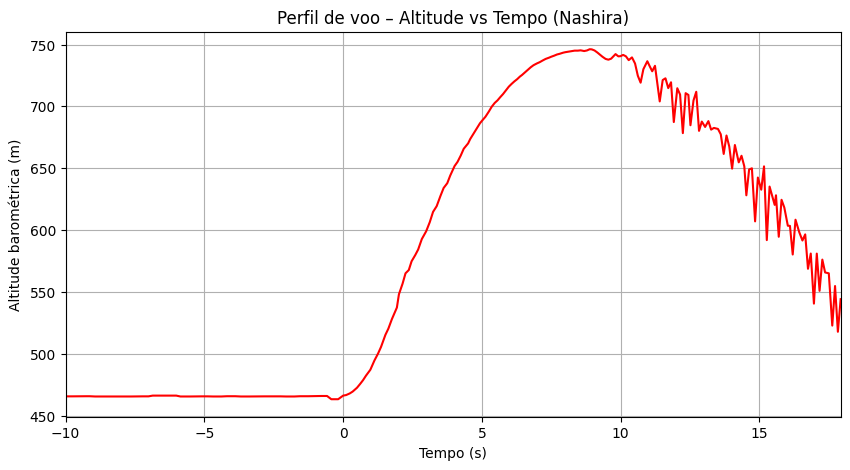

Apogeu do Nashira (telemetria):
Tempo desde o lançamento: 8.88 s
Altitude no apogeu: 746.20 m
Apogeu relativo ao nível do solo: 283.20 m
Velocidade máx. queda aproximada: 55.61 m/s (200 km/h)


In [44]:
# Tempo relativo ao lançamento
t = (df["timestamp_ms"] - launch_time_ms) / 1000.0 #t são os tempos em segundos desde o lançamento

# Mostrar a partir de -10 s
min_time = -10.0
mask_time = t >= min_time 

plt.figure(figsize=(10,5))
plt.plot(t[mask_time], df.loc[mask_time, "alt_bar"], color='red', linewidth=1.5) #loc para manter o alinhamento correto dos índices
plt.xlabel("Tempo (s)")
plt.ylabel("Altitude barométrica (m)")
plt.title("Perfil de voo – Altitude vs Tempo (Nashira)")
plt.grid(True)
plt.xlim(min_time, t.max())
plt.show()

print("Apogeu do Nashira (telemetria):")
apogee_time_nashira = df.loc[df['alt_bar'].idxmax(), 'time_launch_s']
apogee_altitude_nashira = df['alt_bar'].max()
print(f"Tempo desde o lançamento: {apogee_time_nashira:.2f} s")
print(f"Altitude no apogeu: {apogee_altitude_nashira:.2f} m")
print(f"Apogeu relativo ao nível do solo: {apogee_altitude_nashira - env.elevation:.2f} m")


max_fall_raw = df['vel_d'].max() 
max_fall_ms = max_fall_raw / 100.0
max_fall_kmh = max_fall_ms * 3.6
print(f"Velocidade máx. queda aproximada: {max_fall_ms:.2f} m/s ({max_fall_kmh:.0f} km/h)")

Os dados de telemetria do voo do Nashira indicam o alcance do apogeu após 8,88s do lançamento. A descida turbulenta e rápida demonstra uma falha no acionamento dos paraquedas.

### 6. Plotagem comparativa


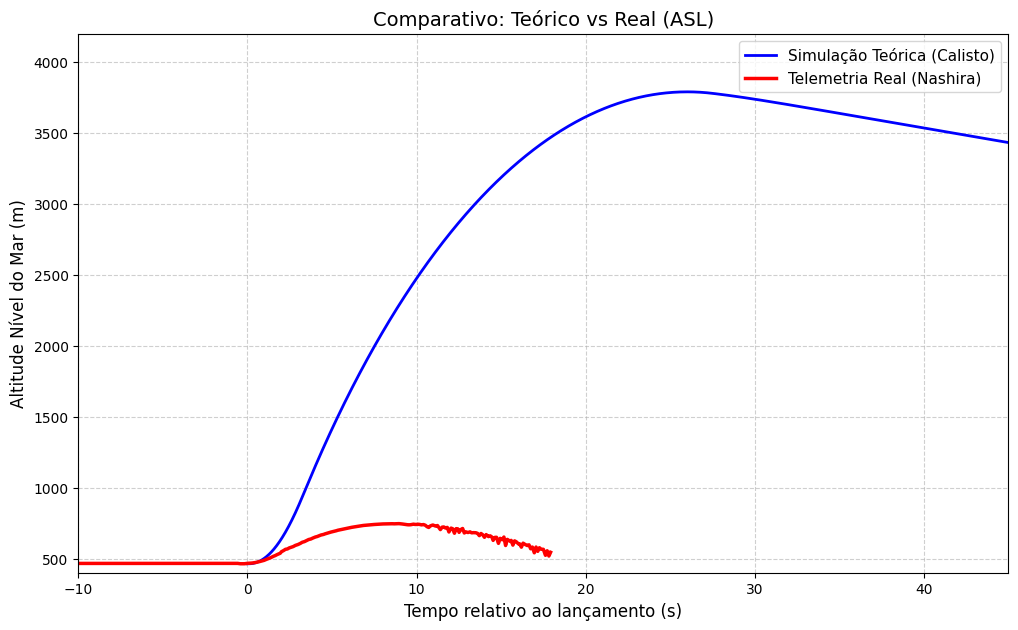

Velocidade de Impacto: -5.38 m/s


In [45]:
min_time = -10.0
mask_time = t >= min_time 


sim_time = flight.time
sim_raw_altitude = flight.altitude # Pega os dados brutos

start_alt_sim = float(np.asarray(sim_raw_altitude[0]).flatten()[0])
elevation_real = 463.0

sim_altitude_plot = np.asarray(sim_altitude(sim_time)) + elevation_real


plt.figure(figsize=(12, 7))

# Azul: Simulação Calisto
plt.plot(sim_time, sim_altitude_plot,
        label='Simulação Teórica (Calisto)', color='blue', linestyle='-', linewidth=2)

# Vermelho: Nashira 
plt.plot(df_filtered['time_launch_s'], df_filtered['alt_bar'],
        label='Telemetria Real (Nashira)', color='red', linewidth=2.5)

plt.title('Comparativo: Teórico vs Real (ASL)', fontsize=14)
plt.xlabel('Tempo relativo ao lançamento (s)', fontsize=12)
plt.ylabel('Altitude Nível do Mar (m)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(min_time, 45)
plt.ylim(400, 4200)
plt.show()

print(f"Velocidade de Impacto: {flight.impact_velocity:.2f} m/s") 



A grande diferença dos gráficos provavelmente se dá devido às características do foguete Calisto frente ao Nashira: enquanto o Calisto é um foguete de 14kg (sem a massa do propelente), o Nashira provavelmente tem o peso menor.

O pós atingimento do apogeu também evidencia a questão dos paraquedas, uma vez que a descida do Calisto pela simulação é bem mais lenta e gradual, contrastando com a queda turbulenta constatada do Nashira

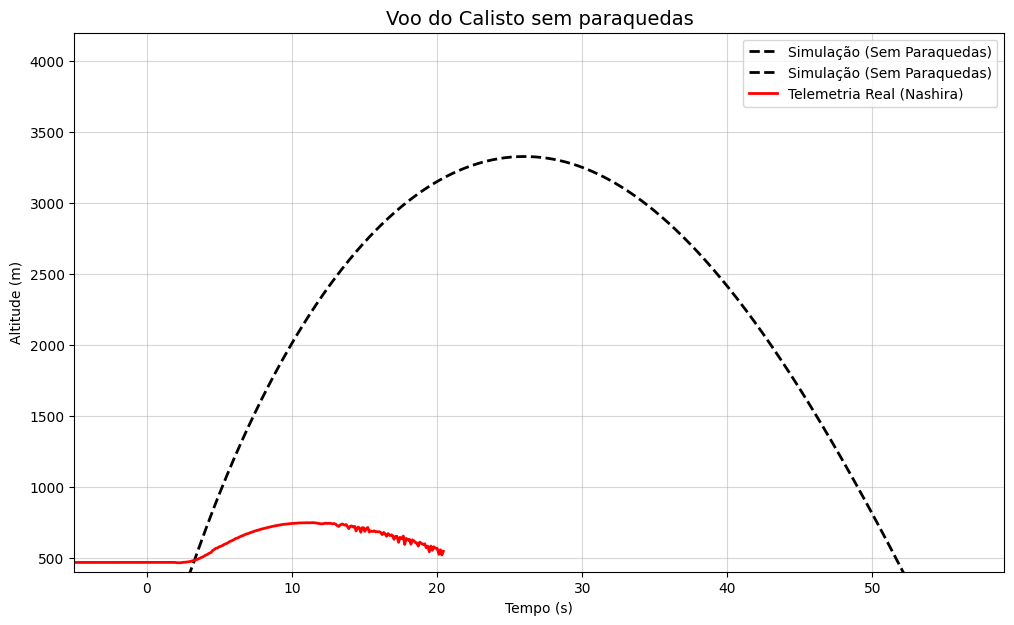

Velocidade de Impacto: -203.93 m/s


In [46]:
# Plotagem do voo sem paraquedas
calisto.parachutes = [] 
flight_2 = Flight(
    rocket=calisto, 
    environment=env, 
    rail_length=5.2, 
    inclination=85, 
    heading=0
)

offset_time = 2.5

plt.figure(figsize=(12, 7))
plt.plot(flight_2.time, flight_2.altitude, label='Simulação (Sem Paraquedas)', color='black',
        linestyle='--', linewidth=2)

# Curva Vermelha (Real Nashira)
plt.plot(df_filtered['time_launch_s'] + offset_time, df_filtered['alt_bar'], 
        label='Telemetria Real (Nashira)', color='red', linewidth=2)

plt.title('Voo do Calisto sem paraquedas', fontsize=14)
plt.xlabel('Tempo (s)')
plt.ylabel('Altitude (m)')
plt.legend()
plt.grid(True, alpha=0.5)

plt.xlim(-5, flight_2.t_final + 5) 
plt.ylim(400, 4200)

plt.show()

print(f"Velocidade de Impacto: {flight_2.impact_velocity:.2f} m/s") 

Pode-se observar que a imagem gerada para a simulação do Calisto, sem o paraquedas, assemelha-se a uma parábola. No entando, é possível constatar que é assimétrica: a subida tem maior coeficiente angular que a descida, que se traduz que a descida é menos íngrime.

Essa ocorrência é justificada pelo arrasto atmosférico. O ar oferece resistência à queda do foguete, freando-o e deixando a queda mais lenta, algo que resulta em determinado momento, na velocidade terminal, que consiste na gravidade ser anulada pelo efeito do arrasto, de modo que a velocidade da queda do foguete passa a ser constante, assemelhando-se a uma reta a partir desse momento.

Ainda assim, vê-se que um foguete mais pesado e de maiores dimensões como o Calisto torna-se extremamente perigoso durante a queda, especialmente com a falha ou ausência de seus paraquedas.

### 7. Filtagem do voo e estimativa do pouso

Resultados da Reconstrução do Pouso do Nashira:
Velocidade Terminal Estimada: -30.52 m/s
Tempo de queda 'não registrado': 2.68 s
                              
Distância Total Percorrida (Pitágoras): 221.14 metros
Direção da Queda (Azimute): 307.71°
Vento Estimado (Vindo de): 127.71°


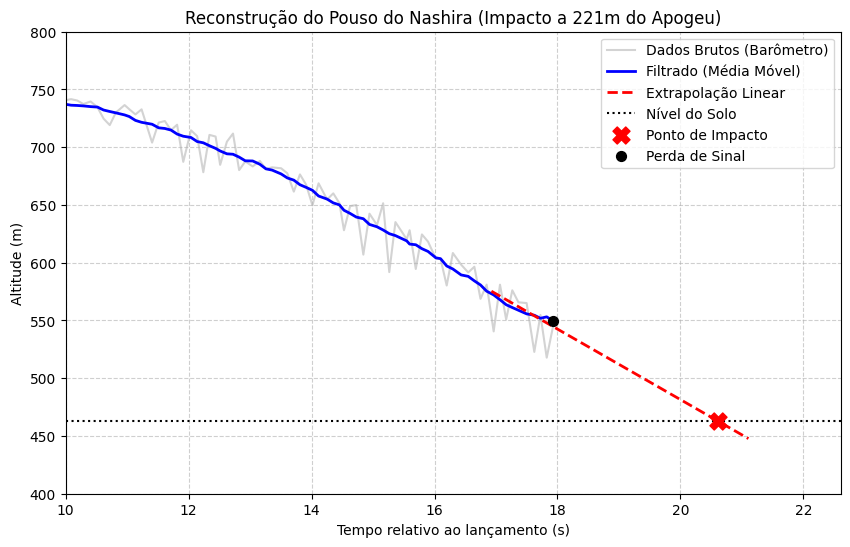

In [47]:
#Análise da telemetria do voo do Nashira para estimar o ponto de pouso, a direção e a velocidade do vento (usado como parâmetro no Environment)

launch_time = 387998  
df['t'] = (df['timestamp_ms'] - launch_time) / 1000.0 # eixo do tempo zerado no lançamento

# FILTRAGEM DE RUÍDO (Suavização)
# A função .rolling(window=15) cria uma "janela deslizante" que pega 15 pontos por vez e tira a média (funciona como uma média móvel)
#Isso elimina picos abruptos (ruído do sensor) e oscilações originadas provavelmente por vibrações do foguete
df['alt_sem_ruido'] = df['alt_bar'].rolling(window=15, center=True, min_periods=1).mean() 

# EXTRAPOLAÇÃO TEMPORAL (Para descobrir o momento do impacto) já que o sinal foi perdido antes de atingir o chão
#pegos os últimos 3 segundos nos quais o foguete já estava em velocidade terminal - queda com velocidade aproximadamente constante
t_max = df['t'].max()
data_final = df[df['t'] > (t_max - 3.0)].copy()  

#valores X e y para regressão linear
X = data_final['t'].values.reshape(-1, 1) #reshape para criar uma matriz coluna
y = data_final['alt_sem_ruido'].values 

#regressão Linear: é traçada a melhor reta por meio do método dos mínimos quadrados
# y = mx + b (Altitude = Velocidade * Tempo + Altitude_inicial)
model = LinearRegression().fit(X, y)
vel_terminal = model.coef_[0] # Inclinação da reta -> a velocidade de descida (m/s)
intercept = model.intercept_ #coeficiente linear da reta

# Cálculo do Tempo de Impacto
ground_alt = 463
t_impact = (ground_alt - intercept) / vel_terminal
time_blind = t_impact - t_max # Quanto tempo o foguete continuou caindo "no escuro"


# CÁLCULO DE DISTÂNCIA - Estimativa da distância percorrida devido ao vento
deg_to_m = 111139.0 #1 grau de latitude ~= 111km
lat_mean = data_final['lat'].mean()
factor_lon = np.cos(np.radians(lat_mean)) # Fórmula para correção da longitude, pois é afastada do Equador

# Cálculo da velocidade lateral média (m/s) nos últimos segundos
dt_mean = np.diff(data_final['t']).mean() 
v_north = (np.diff(data_final['lat']).mean() * deg_to_m) / dt_mean #velocidade média norte-sul
v_east = (np.diff(data_final['lon']).mean() * deg_to_m * factor_lon) / dt_mean #velocidade média leste-oeste


# Percurso sem o sinal gravado
dist_blind_n = v_north * time_blind
dist_blind_e = v_east * time_blind

# Percurso da queda com sinal gravado (do Apogeu até o último sinal)
apogee_idx = df['alt_sem_ruido'].idxmax() 
apogee_lat = df.loc[apogee_idx, 'lat'] 
apogee_lon = df.loc[apogee_idx, 'lon']
last_lat = df.iloc[-1]['lat']
last_lon = df.iloc[-1]['lon']

dist_gravada_n = (last_lat - apogee_lat) * deg_to_m #distancias com os dados gravados
dist_gravada_e = (last_lon - apogee_lon) * deg_to_m * factor_lon

# Soma Total 
total_n = dist_gravada_n + dist_blind_n
total_e = dist_gravada_e + dist_blind_e

# Pitágoras: A distância em linha reta do apogeu ao chão
# Por ser um percurso de poucos metros, a curvatura da Terra é desprezível
total_dist = np.sqrt(total_n**2 + total_e**2)

# Direção: Cálculo do Azimute (ângulo em relação ao Norte)
azimuth = (math.degrees(math.atan2(total_e, total_n)) + 360) % 360 
wind_dir = (azimuth + 180) % 360 # O vento vem do lado oposto


# Resultados
print("Resultados da Reconstrução do Pouso do Nashira:") 
print(f"Velocidade Terminal Estimada: {vel_terminal:.2f} m/s")
print(f"Tempo de queda 'não registrado': {time_blind:.2f} s")
print(" " * 30)
print(f"Distância Total Percorrida (Pitágoras): {total_dist:.2f} metros")
print(f"Direção da Queda (Azimute): {azimuth:.2f}°")
print(f"Vento Estimado (Vindo de): {wind_dir:.2f}°")

# Plotagem 
plt.figure(figsize=(10, 6))

# Dados Brutos (Cinza claro): dados do barômetro com ruído
plt.plot(df['t'], df['alt_bar'], color='lightgray', label='Dados Brutos (Barômetro)', zorder=1) 

# Dados Suavizados (Azul): Mostra a tendência real 
plt.plot(df['t'], df['alt_sem_ruido'], color='blue', linewidth=2, label='Filtrado (Média Móvel)', zorder=2)

# Extrapolação (Vermelho Tracejado): A previsão do percurso até o chão
# t_future é uma linha de tempo artificial que vai do fim dos dados até o impacto
t_future = np.linspace(t_max - 1, t_impact + 0.5, 20)
alt_future = model.predict(t_future.reshape(-1, 1)) # previsão da altitude com base na regressão linear
plt.plot(t_future, alt_future, color='red', linestyle='--', linewidth=2, label='Extrapolação Linear', zorder=3)

# Marcações visuais (Solo e Impacto)
plt.axhline(ground_alt, color='black', linestyle=':', linewidth=1.5, label='Nível do Solo')
plt.scatter(t_impact, ground_alt, color='red', marker='X', s=150, zorder=4, label='Ponto de Impacto')
plt.scatter(t_max, df['alt_sem_ruido'].iloc[-1], color='black', s=50, zorder=4, label='Perda de Sinal')

plt.title(f'Reconstrução do Pouso do Nashira (Impacto a {total_dist:.0f}m do Apogeu)')
plt.xlabel('Tempo relativo ao lançamento (s)')
plt.ylabel('Altitude (m)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
# Zoom na parte final do voo para ver os detalhes
plt.xlim(10, t_impact + 2)
plt.ylim(400, 800)

plt.show()

Estimativa da trajetória final e do ponto de impacto com base em dados de telemetria

Foi realizada uma estimativa para reconstruir a trajetória final do foguete Nashira, uma vez que os últimos dados de telemetria foram registrados quando o veículo ainda se encontrava a aproximadamente 544 m de altitude (alt_bar), mais de 80 m acima do solo. O apogeu ocorreu na posição (latitude, longitude) = (-21,94126; -48,95274), enquanto o último ponto disponível foi registrado em (-21,94052; -48,95426). Devido à perda de sinal antes do impacto, tornou-se necessário estimar o tempo restante de voo, a distância percorrida e a influência do vento na fase final da descida.

Os dados brutos de altitude barométrica apresentavam ruído significativo, possivelmente causado por vibrações do foguete e interferências ambientais, especialmente durante a queda. Para mitigar esse efeito, foi aplicada uma filtragem por média móvel com janela de 15 amostras, utilizando a função '.rolling(window=15).mean()' do pandas. Esse valor foi escolhido empiricamente, para equilibrar a redução de ruído de alta frequência sem comprometer a tendência real do sinal, de modo a permitir a identificação clara do perfil de descida.

Após a filtragem, foram selecionados os últimos 3 segundos de dados válidos, intervalo no qual a análise indicou que o foguete já havia atingido velocidade terminal, caracterizada por aceleração aproximadamente nula. Nessa condição, a descida pode ser modelada como um movimento retilíneo uniforme, descrito pela equação (h(t) = vt + h0). O atingimento da velocidade terminal foi constatado com o cálculo da derivada da velocidade vertical, no código abaixo.

Com base nesse regime estável, aplicou-se uma regressão linear pelo método dos mínimos quadrados, com uso da classe 'LinearRegression' da biblioteca scikit-learn, ajustando a altitude suavizada em função do tempo. A inclinação da reta forneceu uma estimativa da velocidade vertical terminal, enquanto o coeficiente linear permitiu calcular o instante em que a altitude atingiria o nível do solo (463 m). Assim foi estimado o tempo de impacto não registrado pela telemetria. Essa extrapolação assume velocidade constante até o impacto, o que introduz limitações associadas a possíveis variações na resistência do ar e no vento, mas é razoável como estimativa inicial.

Para a reconstrução da trajetória horizontal, assumiu-se que o vento lateral permaneceu constante durante a fase final da queda. A partir da variação das coordenadas de latitude e longitude nos últimos segundos de voo, foi calculada a velocidade média de deslocamento lateral (componentes Norte/Leste). Esse vetor foi então projetado ao longo do tempo estimado sem sinal e somado à última posição registrada pelo GPS, resultando na estimativa da coordenada final de pouso e na conclusão da direção predominante do vento durante a descida.


Velocidade Terminal Média (últimos s): -30.52 m/s


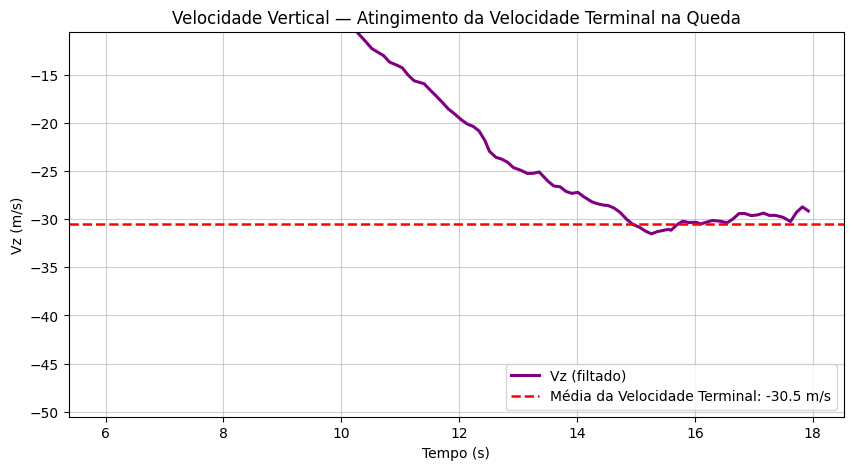

In [48]:
# Velocidade vertical e estimação da terminal
t_max = df['t'].max()

# derivada da altitude suavizada 
df['vz_raw'] = np.gradient(df['alt_sem_ruido'], df['t']) #derivada numérica da altitude em relação ao tempo
df['vz_smooth'] = df['vz_raw'].rolling(window=40, center=True, min_periods=1).mean()
#foi usada uma janela maior (40) para suavizar mais o sinal de velocidade, que estava muito ruidoso, e amplificado por ser uma derivada

vel_terminal_media = LinearRegression().fit(X, y).coef_[0] 
print(f"Velocidade Terminal Média (últimos s): {vel_terminal_media:.2f} m/s")

fase_final = df[df['t'] > (t_max - 12)].copy() 
plt.figure(figsize=(10,5))
plt.plot(fase_final['t'], fase_final['vz_smooth'], color='purple', lw=2.2, label='Vz (filtado)')
plt.axhline(vel_terminal_media, color='red', ls='--', lw=1.8,
            label=f'Média da Velocidade Terminal: {vel_terminal_media:.1f} m/s')
plt.title("Velocidade Vertical — Atingimento da Velocidade Terminal na Queda")
plt.xlabel("Tempo (s)"); plt.ylabel("Vz (m/s)")
plt.legend(loc='lower right'); plt.grid(alpha=0.6)
plt.ylim(vel_terminal_media - 20, vel_terminal_media + 20)
plt.show()


Acima foi comprovado o atingimento da velocidade terminal, com a estabilização da velocidade vertical do foguete.

### 8. Comparação dos dados

In [49]:
# Dados da simulação
sim_apogee = flight_2.apogee - env.elevation
sim_t_apogee = flight_2.apogee_time
sim_max_vel = max(flight_2.vz[:, 1]) # Máxima na subida
sim_flight_time = flight_2.t_final 
sim_impact_velocity = flight_2.impact_velocity 

# Métricas calculadas do voo do Nashira
real_apogee = df['alt_sem_ruido'].max() - env.elevation
real_t_apogee = df.loc[df['alt_sem_ruido'].idxmax(), 't']
real_max_vel = df['vz_smooth'].max() 
real_flight_time = t_impact # Calculado na extrapolação
real_impact_velocity = vel_terminal_media # Calculado na extrapolação


# Tabela de erro
metrics = {
    "Apogeu (AGL) [m]": (sim_apogee, real_apogee),
    "Tempo Apogeu [s]": (sim_t_apogee, real_t_apogee),
    "Velocidade Máx [m/s]": (sim_max_vel, real_max_vel),
    "Tempo Total [s]": (sim_flight_time, real_flight_time),
    "Velocidade Impacto [m/s]": (sim_impact_velocity, real_impact_velocity) 
}

print(f"{'MÉTRICA':<30} | {'SIMULAÇÃO':<12} | {'REAL (NASHIRA)':<15} | {'ERRO (%)':<10}")
print("" * 78)

for metric, (sim, real) in metrics.items():
    # Cálculo do erro relativo: (Valor Real - Valor Teórico) / Valor Teórico
    diff = real - sim
    err_perc = (diff / sim) * 100

    print(f"{metric:<30} | {sim:<12.2f} | {real:<15.2f} | {err_perc:>+9.1f}%")

MÉTRICA                        | SIMULAÇÃO    | REAL (NASHIRA)  | ERRO (%)  

Apogeu (AGL) [m]               | 3327.22      | 281.47          |     -91.5%
Tempo Apogeu [s]               | 26.01        | 8.46            |     -67.5%
Velocidade Máx [m/s]           | 284.57       | 47.90           |     -83.2%
Tempo Total [s]                | 54.09        | 20.61           |     -61.9%
Velocidade Impacto [m/s]       | -203.93      | -30.52          |     -85.0%


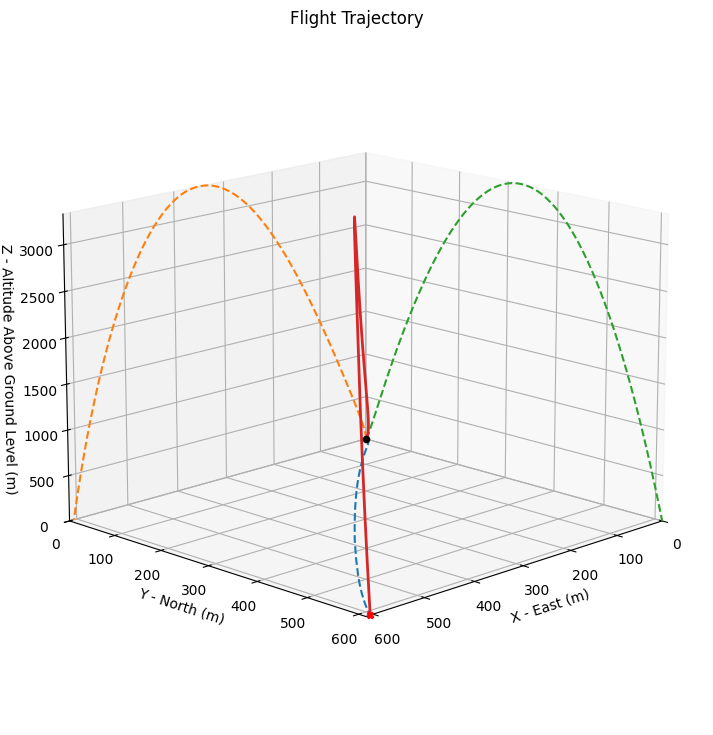

In [50]:
flight_2.plots.trajectory_3d()

O trecejado parabólico azul no plano xy evidencia a influência do vento no percurso do foguete.

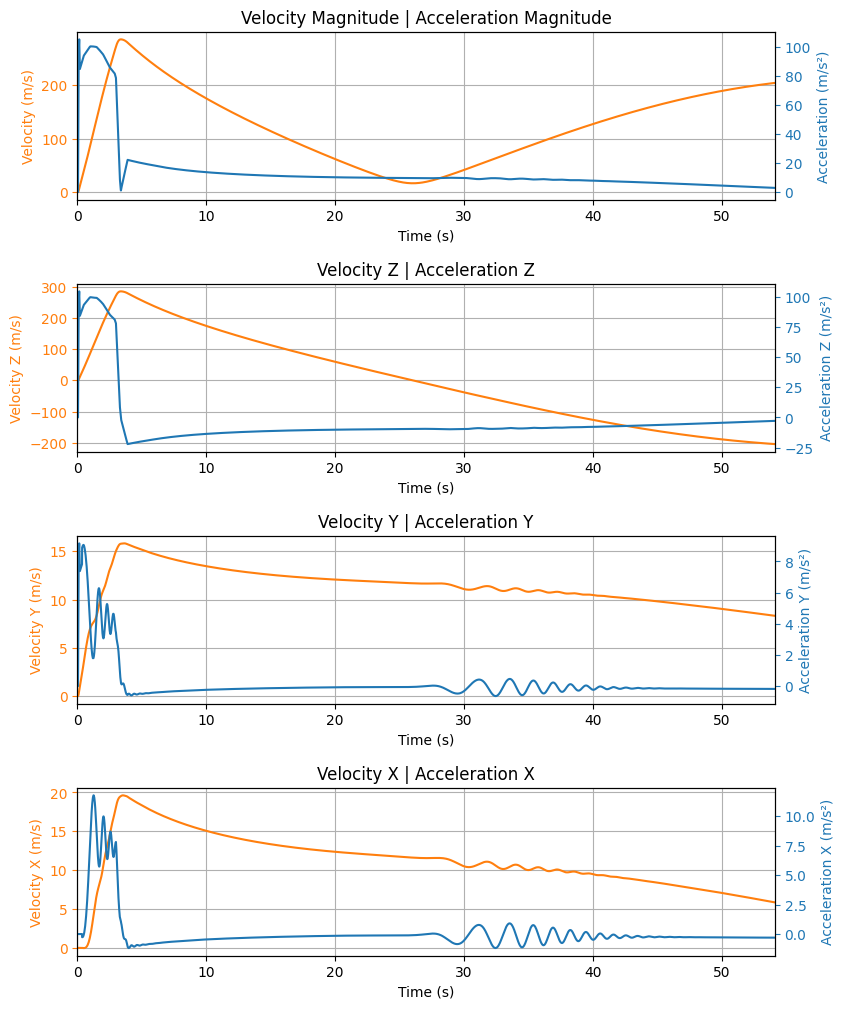

In [51]:
flight_2.plots.linear_kinematics_data()

O resultado do gráfico Velocity Z x Time traz resultados interessantes, ao mostrar que o foguete Calisto não chegou a atingir a velocidade terminal, uma vez que é possível ver uma redução do coeficiente angular, mas não chega a zerar.  

### 9. Conclusões
A escolha do foguete Calisto com o motor Cesaroni apresentou diversas divergências em relação ao voo real do Nashira. Uma vez que não foram especificadas as características físicas do Nashira e de seu motor, a seleção do modelo virtual pôde utlizar o Calisto por padrão. Ao invés de tentar replicar o voo do Nashira com vários modelos aleatórios - o que poderia gerar problemas de inconsistência física - optou-se por validar a análise de comparação de um vôo real com um modelo de voo como referência.

Feita a simulação com a referida configuração, foi possível constatar que o conjunto Calisto/Cesaroni compõe uma categoria bem superior em relação a qual o Nashira foi desenvolvido - isso foi evidenciado na discrepância de apogeu (3km x 280m).

Ainda assim, a análise comparativa permitiu observar ocorrências como falha de recuperação - com o não acionamento dos paraquedas - e da descida menos estável do Nashira; da influência do vento como componente atuante no deslocamento horizontal; as técnicas de filtragem de dados e extrapolação numérica mostraram-se satisfatóras para preencher as lacunas deixadas pela perda de sinal, sendo geradas estimativas de local do pouso e da velocidade de impacto.